In [54]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install tqdm
%pip install scikit-learn
%pip install torch
%pip install transformers
%pip install nltk


import pandas as pd
import numpy as np
import re
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm


import torch
from transformers import BertTokenizer, BertModel


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    precision_recall_curve,
    average_precision_score
)


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\yarid\appdata\local\programs\python\python310\lib\site-packages (1.5.3)



You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Yarid\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [55]:
def balance_check(data, target):
    try:
        df = pd.read_csv(data)
    except:
        print("Error Reading cannot be found")
        return

    #now check value counts
    ones_percentage = df[target].value_counts(normalize=True).loc[1] * 100
    print(f"Percentage of 1s for : {ones_percentage:.2f}%")

    return



In [56]:
balance_check("data/train.csv/train.csv","toxic")
balance_check("data/train.csv/train.csv","severe_toxic")
balance_check("data/train.csv/train.csv","obscene")
balance_check("data/train.csv/train.csv","threat")
balance_check("data/train.csv/train.csv","insult")
balance_check("data/train.csv/train.csv","identity_hate")

Percentage of 1s for : 9.58%
Percentage of 1s for : 1.00%
Percentage of 1s for : 5.29%
Percentage of 1s for : 0.30%
Percentage of 1s for : 4.94%
Percentage of 1s for : 0.88%


In [57]:
df1 = pd.read_csv("data/train.csv/train.csv")
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [59]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

#  NLTK Fix for LookupError
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk_path = os.path.join(os.path.expanduser('~'), 'AppData', 'Roaming', 'nltk_data')
if nltk_path not in nltk.data.path:
    nltk.data.path.append(nltk_path)
try:
    _ = stopwords.words('english')
except LookupError as e:
    print("NLTK stopwords resource not found, attempting to download again...")
    nltk.download('stopwords')
    _ = stopwords.words('english')

def load_dataset(file_path):
    try:
        df = pd.read_csv(file_path)

        print("Dataset loaded successfully!")
        print(f"Shape: {df.shape}")

        # check for null values
        print("\nNull values per column:")
        print(df.isnull().sum())

        return df

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # remove artifacts and wikimarkups
    text = re.sub(r'==.*?==+', '', text)
    text = re.sub(r'\[\[.*?\]\]', '', text)
    text = re.sub(r'\{\{.*?\}\}', '', text)
    text = re.sub(r'__[A-Z]+__', '', text)
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r'<.*?>', '', text)

    # URLs, IPs, timestamps, extra spaces, and lowercasing
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', '', text)
    text = re.sub(r'\d{1,2}:\d{2},?\s*\d{1,2}\s+\w+\s+\d{4}', '', text)
    text = re.sub(r"[^\w\s'!?.]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    return text

def remove_stopwords(text):
    try:
        stop_words = set(stopwords.words('english'))

        custom_stopwords = {
            'wikipedia', 'page', 'article', 'edit', 'user', 'talk',
            'section', 'redirect', 'category', 'file', 'image', 'template'
        }
        stop_words.update(custom_stopwords)

        negation_words = {
            'not', 'no', 'never', 'none', 'nor', 'neither',
            "don't", "isn't", "aren't", "wasn't", "weren't",
            "haven't", "hasn't", "hadn't", "won't", "wouldn't"
        }
        stop_words -= negation_words

        tokens = word_tokenize(text)
        filtered_tokens = [
            word for word in tokens 
            if word not in stop_words and len(word) > 2 and not word.startswith("'")
        ]

        return ' '.join(filtered_tokens)
    except LookupError as e:
        if "stopwords" in str(e) or "punkt" in str(e):
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            try:
                stop_words = set(stopwords.words('english'))
                tokens = word_tokenize(text)
                return ' '.join(tokens)  # fallback: just tokenize
            except Exception:
                return text  # worst case: return raw text
        return text

def initialize_bert():
    print("\nInitializing BERT model...")
    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')
        print("BERT initialized successfully")
        return tokenizer, model
    except Exception as e:
        print(f"Error initializing BERT: {e}")
        return None, None

if __name__ == "__main__":
    FILE_PATH = "data/train.csv/train.csv"

    print("Starting Toxic Comment Classification Pipeline")
    df = load_dataset(FILE_PATH)

    if df is not None:
        df['cleaned_text'] = df['comment_text'].apply(clean_text)
        df['processed_text'] = df['cleaned_text'].apply(remove_stopwords)

        # show some examples of cleaning
        print("\nText processing examples:")
        for i in range(3):
            print(f"\nOriginal {i}:")
            print(df['comment_text'].iloc[i])
            print("\nProcessed:")
            print(df['processed_text'].iloc[i])
            print("-"*50)

        bert_tokenizer, bert_model = initialize_bert()

        if bert_tokenizer:
            print("\nTokenization example:")
            sample_text = df['processed_text'].iloc[0]
            print(f"\nSample text: {sample_text}")

            tokens = bert_tokenizer.tokenize(sample_text)
            print(f"\nTokens: {tokens}")

            token_ids = bert_tokenizer.encode(sample_text, add_special_tokens=True)
            print(f"\nToken IDs: {token_ids}")

    print("\nPipeline execution complete")


Starting Toxic Comment Classification Pipeline
Dataset loaded successfully!
Shape: (159571, 8)

Null values per column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Text processing examples:

Original 0:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Processed:
explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.
--------------------------------------------------

Original 1:
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk)

c:\Users\Yarid\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERT initialized successfully

Tokenization example:

Sample text: explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.

Tokens: ['explanation', 'why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'hardcore', 'metallic', '##a', 'fan', 'were', 'reverted', '?', 'they', 'weren', "'", 't', 'van', '##dal', '##isms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fa', '##c', '.', 'and', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired', 'now', '.']

Token IDs: [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 1029, 2027, 4694, 1005, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 20

In [60]:

if df is not None:
    df['cleaned_text'] = df['comment_text'].apply(clean_text)
    df['processed_text'] = df['cleaned_text'].apply(remove_stopwords)


In [ ]:

batch_size = 64
embeddings = []

# Process in batches
for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['processed_text'].iloc[i:i+batch_size].tolist()
    inputs = bert_tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token outputs
    embeddings.append(cls_embeddings)

    
df['bert_embedding'] = np.vstack(embeddings).tolist()


In [61]:
repo_root = Path().resolve()
emb_path  = repo_root / "trained_embeddings.csv"

df = pd.read_csv(emb_path)

# 3) Extract the numbers into real arrays
def extract_numbers(s):
    if isinstance(s, str):
        # fix potential corruptions in the file 
        s = s.replace("\n", " ")
        nums = re.findall(r"-?\d+\.\d+e[+-]?\d+|-?\d+\.\d+|-?\d+", s)
        return np.array(list(map(float, nums)))
    return np.array([])

df["bert_embedding"] = df["bert_embedding"].apply(extract_numbers)


In [62]:
# Show the shape of the embeddings and a preview
print("\nBERT embeddings preview:")
print(df['bert_embedding'].head(3))  # we can show the first 3


BERT embeddings preview:
0    [-0.314486623, -0.0908075944, -0.13584879, -0....
1    [-0.64000684, -0.159012794, 0.136123598, -0.32...
2    [0.0685186237, 0.185241759, -0.125454396, -0.1...
Name: bert_embedding, dtype: object


In [63]:
df[['processed_text', 'bert_embedding']].head(3)


,processed_text,bert_embedding
0,explanation edits made username hardcore metal...,"[-0.314486623, -0.0908075944, -0.13584879, -0...."
1,d'aww matches background colour seemingly stuc...,"[-0.64000684, -0.159012794, 0.136123598, -0.32..."
2,hey man really not trying war guy constantly r...,"[0.0685186237, 0.185241759, -0.125454396, -0.1..."


In [ ]:
#save the embeddings to csv so we don't have to rerun the code -  don't need to rerun this cell this is for just saving the embeddings

df.to_csv("data/trained_embeddings.csv", index=False)


In [65]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,processed_text,bert_embedding
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,"[-0.314486623, -0.0908075944, -0.13584879, -0...."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...,d'aww matches background colour seemingly stuc...,"[-0.64000684, -0.159012794, 0.136123598, -0.32..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war. it'...,hey man really not trying war guy constantly r...,"[0.0685186237, 0.185241759, -0.125454396, -0.1..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,n't make real suggestions improvement wondered...,"[0.0859799385, 0.389762282, 0.223314866, -0.11..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero. any chance you remember w...,sir hero chance remember,"[-0.135686234, 0.146607906, -0.0853934884, -0...."


In [66]:
df.drop('comment_text', axis=1, inplace=True)  # Drop original text column
df.drop('cleaned_text', axis=1, inplace=True)  # Drop cleaned text column
df.drop('processed_text', axis=1, inplace=True)  # Drop processed text column
df.drop('id', axis=1, inplace=True)  # Drop BERT embedding column
df.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,bert_embedding
0,0,0,0,0,0,0,"[-0.314486623, -0.0908075944, -0.13584879, -0...."
1,0,0,0,0,0,0,"[-0.64000684, -0.159012794, 0.136123598, -0.32..."
2,0,0,0,0,0,0,"[0.0685186237, 0.185241759, -0.125454396, -0.1..."
3,0,0,0,0,0,0,"[0.0859799385, 0.389762282, 0.223314866, -0.11..."
4,0,0,0,0,0,0,"[-0.135686234, 0.146607906, -0.0853934884, -0...."


In [67]:
#splitting data into train and test

features = ['bert_embedding']
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x= df[features]
y = df[target_columns]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)   
print(f"Shape of X_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (127656, 1)
Shape of y_train: (127656, 6)
Shape of X_test: (31915, 1)
Shape of y_test: (31915, 6)


In [68]:
# run classifier

def run_multilabel_svm(X_train, y_train, X_test, y_test):
    clf = OneVsRestClassifier(LinearSVC(max_iter=5000, dual=False))
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)

    # Performance metrics 
    metrics = {
      'train_accuracy':  accuracy_score(y_train, y_pred_train),
      'test_accuracy':   accuracy_score(y_test,  y_pred_test),
      'train_precision': precision_score(y_train, y_pred_train, average='micro'),
      'test_precision':  precision_score(y_test,  y_pred_test,  average='micro'),
      'train_recall':    recall_score(y_train,    y_pred_train, average='micro'),
      'test_recall':     recall_score(y_test,     y_pred_test,  average='micro'),
      'train_f1':        f1_score(y_train,        y_pred_train, average='micro'),
      'test_f1':         f1_score(y_test,         y_pred_test,  average='micro'),
    }

    return clf, metrics

X_train = np.vstack(x_train['bert_embedding'])
X_test  = np.vstack(x_test['bert_embedding'])

clf, results = run_multilabel_svm(X_train, y_train, X_test, y_test)

print("Performance Metric Results")
for name, val in results.items():
    print(f"{name:15s}: {val:.4f}")


Performance Metric Results
train_accuracy : 0.9153
test_accuracy  : 0.9110
train_precision: 0.8460
test_precision : 0.8164
train_recall   : 0.5404
test_recall    : 0.5141
train_f1       : 0.6595
test_f1        : 0.6309


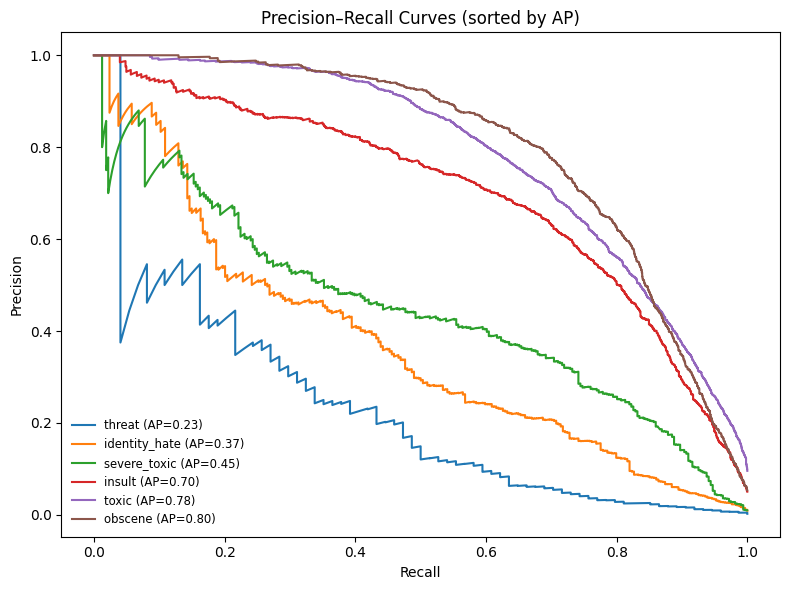

In [111]:

y_scores = clf.decision_function(X_test)
ap_scores = {
    label: average_precision_score(y_test.iloc[:, i], y_scores[:, i])
    for i, label in enumerate(target_columns)
}
sorted_labels = sorted(target_columns, key=lambda l: ap_scores[l])


plt.figure(figsize=(8, 6))

for label in sorted_labels:
    i = target_columns.index(label)
    precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], y_scores[:, i])
    ap = ap_scores[label]
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (sorted by AP)")
plt.legend(loc="lower left", fontsize="small", frameon=False)
plt.tight_layout()
plt.show()


c:\Users\Yarid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

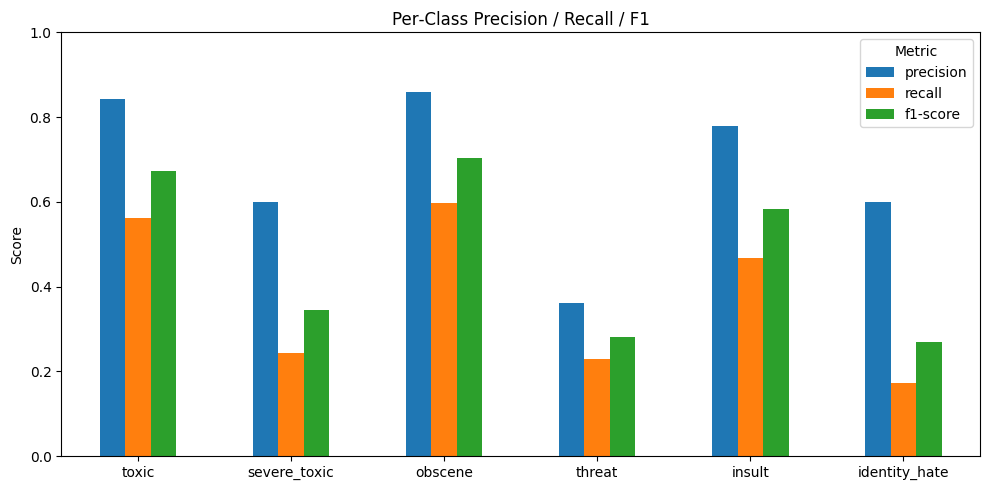

In [70]:

# 1) Predict on the test set
y_pred = clf.predict(X_test)


report = classification_report(
    y_test, 
    y_pred, 
    target_names=target_columns, 
    output_dict=True
)


df_report = pd.DataFrame(report).T.loc[target_columns, ['precision','recall','f1-score']]


ax = df_report.plot.bar(
    figsize=(10,5),
    rot=0,
    ylim=(0,1)
)
ax.set_title("Per‐Class Precision / Recall / F1")
ax.set_ylabel("Score")
plt.legend(title="Metric", loc="upper right")
plt.tight_layout()
plt.show()


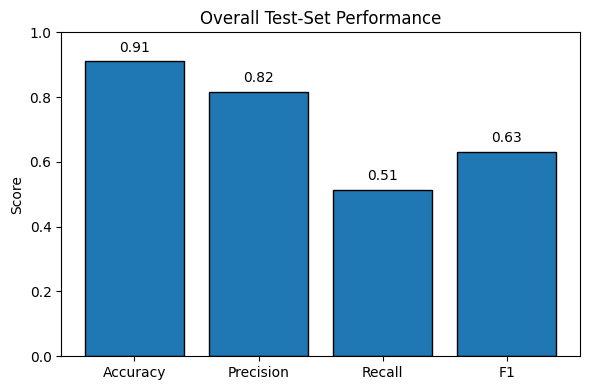

In [71]:

test_metrics = {
    'Accuracy':  results['test_accuracy'],
    'Precision': results['test_precision'],
    'Recall':    results['test_recall'],
    'F1':        results['test_f1']
}


plt.figure(figsize=(6,4))
bars = plt.bar(test_metrics.keys(), test_metrics.values(), edgecolor='k')
plt.ylim(0,1)
plt.title("Overall Test‐Set Performance")
plt.ylabel("Score")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.2f}", 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [109]:

X_all = np.vstack(df['bert_embedding'])

# Predict if toxic or not 
df['predicted'] = clf.predict(X_all)[:, 0]

hate_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

toxic_rates = {}
for label in hate_labels:
    group = df[df[label] == 1]
    if len(group) > 0:
        toxic_rates[label] = group['predicted'].mean()


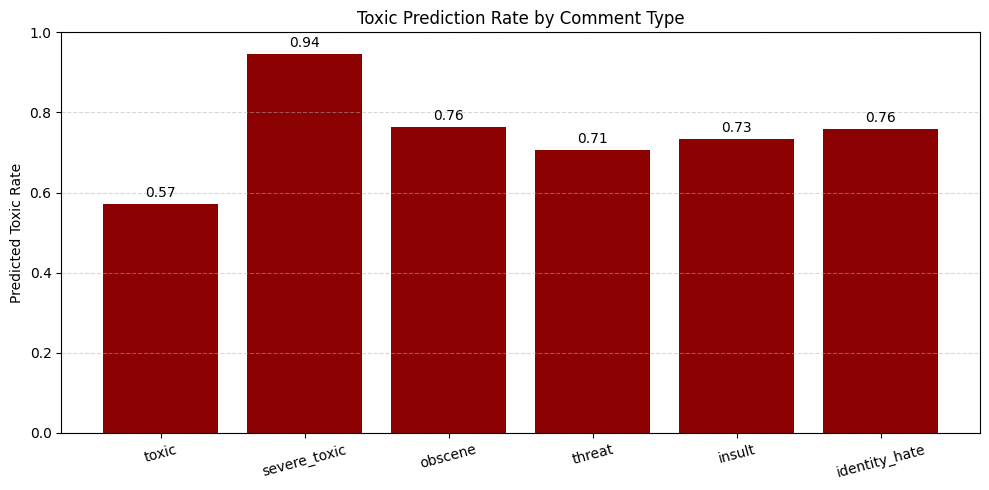

In [110]:
plt.figure(figsize=(10, 5))
bars = plt.bar(toxic_rates.keys(), toxic_rates.values(), color='darkred')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.ylabel("Predicted Toxic Rate")
plt.title("Toxic Prediction Rate by Comment Type")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()